In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization, Reshape
from keras.models import Sequential, Model, load_model
import tensorflow as tf

Для обучения изменить пути до соответствующих частей датасета

In [14]:
path_clean = "C:/Users/a.aspidov/Desktop/attachments/train/clean"
path_noisy = "C:/Users/a.aspidov/Desktop/attachments/train/noisy"
path_val_clean = "C:/Users/a.aspidov/Desktop/attachments/val/val/clean/"
path_val_noisy = "C:/Users/a.aspidov/Desktop/attachments/val/val/noisy/"

In [13]:
def normalize_samples(samples_raw):
    mod = [s - s.min() for s in samples_raw]
    mod = [(s / s.max()).T for s in mod]

    min_len = 48
    normalized = []

    for s in mod:
        if s.shape[1] % min_len == 0:
            normalized += [s[:, min_len * i:min_len * (i + 1)] for i in range(s.shape[1] // min_len)]
        else:
            normalized += [s[:, min_len * i:min_len * (i + 1)] for i in range(s.shape[1] // min_len + 1)]
            normalized[-1] = np.pad(normalized[-1], ((0, 0), (0, min_len - s.shape[1] % min_len)), 'constant')
    return np.array(normalized)

def load_dataset_part(path_base):
    path_list = [os.path.join(path_base, speaker, file) for speaker in
                os.listdir(path_base) for file in
                os.listdir(os.path.join(path_base, speaker))]
    mel_list = np.array([np.load(path) for path in path_list])
    return mel_list

noisy_samples_raw = load_dataset_part(path_noisy)
clean_samples_raw = load_dataset_part(path_clean)
noisy_val_raw = load_dataset_part(path_val_noisy)
clear_val_raw = load_dataset_part(path_val_clean)

noisy_samples_raw = normalize_samples(noisy_samples_raw)
clean_samples_raw = normalize_samples(clean_samples_raw)
noisy_val_raw = normalize_samples(noisy_val_raw)
clear_val_raw = normalize_samples(clear_val_raw)

data = np.concatenate([noisy_samples_raw, clean_samples_raw])
labels = np.concatenate([np.ones(len(noisy_samples_raw)),
                         np.zeros(len(clean_samples_raw))])

x_val = np.concatenate([noisy_val_raw, clear_val_raw])
labels_val = np.concatenate([np.ones(len(noisy_val_raw)), np.zeros(len(clear_val_raw))])

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(labels_val)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

C:\Users\AD86A~1.ASP\AppData\Local\Temp/ipykernel_2580/4168621121.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mel_list = np.array([np.load(path) for path in path_list])


((352121, 80, 48), (352121, 2), (64934, 80, 48), (64934, 2))

In [15]:
with open('xtest.npy', 'wb') as f:
    np.save(f, x_test)
with open('ytest.npy', 'wb') as f:
    np.save(f, y_test)

In [5]:
def build_base_network():
    
    seq = Sequential()
    kernel_size = 3
    
    seq.add(Conv2D(16, (kernel_size, kernel_size), input_shape=(80, 48, 1)))
    seq.add(Conv2D(16, (kernel_size, kernel_size)))
    seq.add(Activation('relu'))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Dropout(0.4))
    
    seq.add(Conv2D(32, (kernel_size, kernel_size)))
    seq.add(Conv2D(32, (kernel_size, kernel_size)))
    seq.add(Activation('relu'))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Dropout(0.4))
    
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.5))
    seq.add(Dense(32, activation='relu'))
    seq.add(Dense(2, activation='sigmoid'))
    return seq

n_epochs = 50
model = build_base_network()
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

In [6]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), verbose=2, epochs=n_epochs)

Epoch 1/50
11004/11004 - 121s - loss: 0.2533 - accuracy: 0.8976 - val_loss: 0.3152 - val_accuracy: 0.8712 - 121s/epoch - 11ms/step
Epoch 2/50
11004/11004 - 112s - loss: 0.1817 - accuracy: 0.9311 - val_loss: 0.2331 - val_accuracy: 0.9171 - 112s/epoch - 10ms/step
Epoch 3/50
11004/11004 - 111s - loss: 0.1620 - accuracy: 0.9398 - val_loss: 0.1868 - val_accuracy: 0.9333 - 111s/epoch - 10ms/step
Epoch 4/50
11004/11004 - 112s - loss: 0.1487 - accuracy: 0.9460 - val_loss: 0.1524 - val_accuracy: 0.9462 - 112s/epoch - 10ms/step
Epoch 5/50
11004/11004 - 112s - loss: 0.1402 - accuracy: 0.9492 - val_loss: 0.1537 - val_accuracy: 0.9430 - 112s/epoch - 10ms/step
Epoch 6/50
11004/11004 - 112s - loss: 0.1347 - accuracy: 0.9524 - val_loss: 0.1471 - val_accuracy: 0.9503 - 112s/epoch - 10ms/step
Epoch 7/50
11004/11004 - 111s - loss: 0.1303 - accuracy: 0.9538 - val_loss: 0.1436 - val_accuracy: 0.9451 - 111s/epoch - 10ms/step
Epoch 8/50
11004/11004 - 111s - loss: 0.1271 - accuracy: 0.9550 - val_loss: 0.1611 

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

<IPython.core.display.Javascript object>


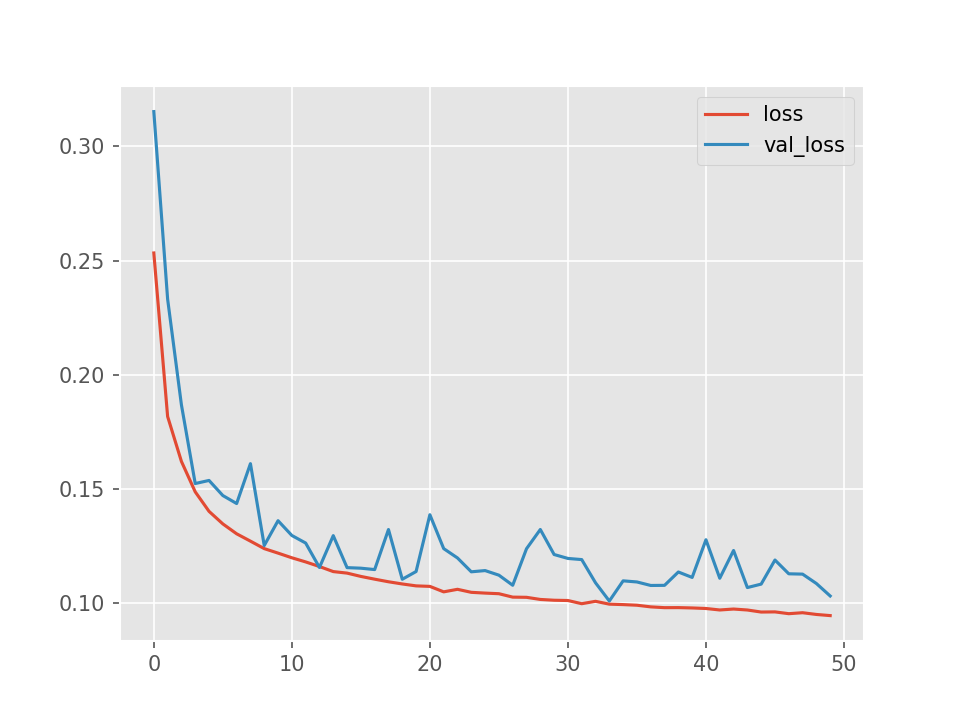

In [8]:
plt.figure()
plt.style.use('ggplot')
plt.plot(range(n_epochs), loss, label='loss')
plt.plot(range(n_epochs), val_loss, label='val_loss')
plt.legend()

<IPython.core.display.Javascript object>


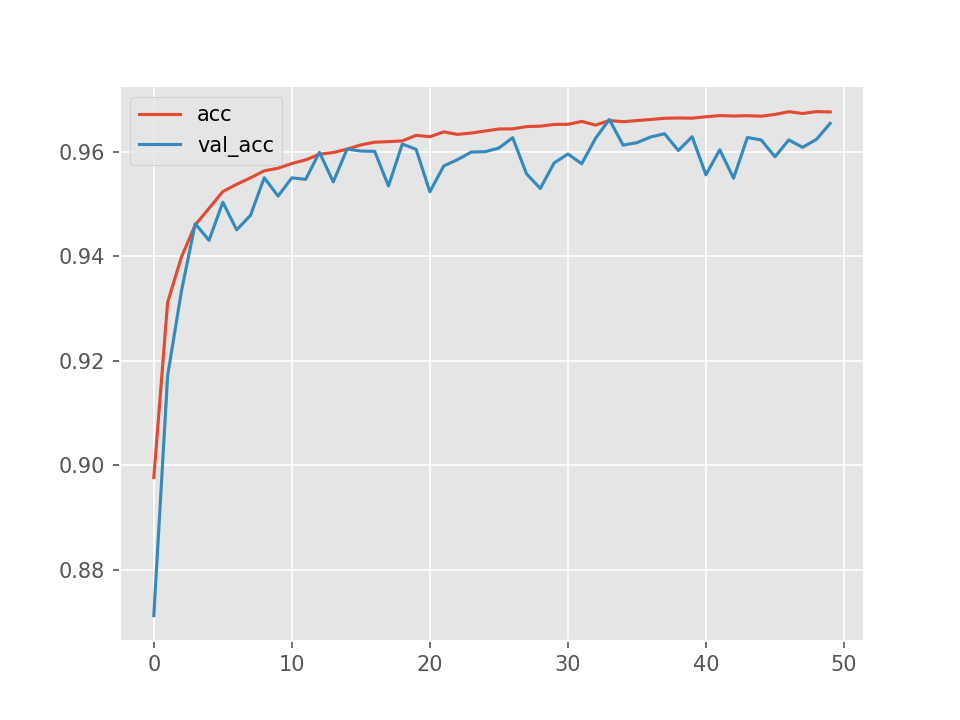

In [9]:
plt.figure()
plt.plot(range(n_epochs), acc, label='acc')
plt.plot(range(n_epochs), val_acc, label='val_acc')
plt.legend()

In [11]:
model.save('model_21.h5')